In [79]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import open3d as o3d
import csv
import torch
import open3d as o3d
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from models import pointnet2_cls_ssg as pcsmodel
from math import floor
import time
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import fastprogress
plt.ion() 
import seaborn as sns
import json

In [80]:
dataset_path = "/run/user/1000/gvfs/smb-share:server=nas-register.local,share=register/hemant/master_thesis/pointclouds"
nofloor_dir = os.path.join(dataset_path, "no_floor")

In [81]:
# pcd = o3d.io.read_point_cloud(os.path.join(nofloor_dir,"2021-12-21", "pointcloud","no_floor" ,"2021-12-21_plant_001.pcd"))
pcd = o3d.io.read_point_cloud(os.path.join(dataset_path,"2021-12-21/pointcloud", "raw/2021-12-21_plant_001.pcd"))
#o3d.visualization.draw_geometries([pcd])

### Combining Dataset

In [82]:
def downsample_pcd(pcd ,num_pts):
#     factor = pcd.shape[0]//num_pts
    indices = np.random.permutation(np.asarray(pcd.points).shape[0])[:num_pts]
    pcd = pcd.select_by_index(indices)
    return pcd
    
def get_mappings():
    mappings = {}
    for i in range(1,13):
        mappings[i] = i

    tags = [11,4,1,9,7,5,10,3,2,6,8,12,7,4,2,1,5,9,11,3,10,12,8,6,5,8,7,6,1,12,2,9,11,3,10,4]

    for i in range(len(tags)):
        mappings[i+13] = tags[i] 
    return mappings

mappings = get_mappings()

In [83]:
new_pcd = downsample_pcd(pcd, 400_000)

In [84]:
o3d.io.write_point_cloud("output.pcd", new_pcd)

True

In [109]:
def get_raw_point_clouds(path):
    res = []
    files = sorted(os.listdir(path), key = lambda x: int(x))
    for folder in files:
        curr_path = os.path.join(path, folder)
        for pcd in sorted(os.listdir(curr_path)):
            complete_path = os.path.join(curr_path, pcd)
            res.append(complete_path)
    return sorted(res, key = lambda x: x.split('_')[-1])

In [111]:
#get_raw_point_clouds(os.path.join(dataset_path, '2021-12-07/pointcloud/raw'))

In [112]:
def generate_csv(path, mappings):
    # date->pointcloud->[4 dirs]->pointclouds
    with open("dataset.csv", 'w+', newline = '') as file:
        writer = csv.writer(file)
        dates = os.listdir(path)
        for date in sorted(dates):
            complete_path = os.path.join(path, date, "pointcloud")
            variation_dirs = [ i for i in os.listdir(complete_path) if 'label' not in i]
            print()
            print(date)
            for vd in variation_dirs:
                curr_path = os.path.join(complete_path, vd)
                if len(sorted(os.listdir(curr_path))) < 48:
                    pcds = get_raw_point_clouds(curr_path)
                else:
                    pcds = [i for i in sorted(os.listdir(curr_path)) if i.endswith('.pcd')]
                print(vd, len(pcds))
                for idx, pcd in enumerate(pcds):
                    
                    writer.writerow([os.path.join(curr_path, pcd), mappings[idx+1]])
            print("done for date {}".format(date))
        
#     complete_path = os.path.join

In [113]:
generate_csv(dataset_path, mappings)


2021-10-26
no_outliers_x2 48
raw 48
no_outliers 48
no_floor 48
done for date 2021-10-26

2021-10-29
no_outliers_x2 48
raw 48
no_outliers 48
no_floor 48
done for date 2021-10-29

2021-11-02
no_outliers_x2 48
raw 48
no_outliers 48
no_floor 48
done for date 2021-11-02

2021-11-05
no_outliers_x2 48
raw 48
no_outliers 48
no_floor 48
done for date 2021-11-05

2021-11-09
no_outliers_x2 48
raw 48
no_outliers 48
no_floor 48
done for date 2021-11-09

2021-11-12
no_outliers_x2 48
raw 48
no_outliers 48
no_floor 48
done for date 2021-11-12

2021-11-16
no_outliers_x2 48
raw 48
no_outliers 48
no_floor 48
done for date 2021-11-16

2021-11-19
no_outliers_x2 48
raw 48
no_outliers 48
no_floor 48
done for date 2021-11-19

2021-11-23
no_outliers_x2 48
raw 48
no_outliers 48
no_floor 48
done for date 2021-11-23

2021-11-30
no_outliers_x2 48
raw 48
no_outliers 48
no_floor 48
done for date 2021-11-30

2021-12-03
no_outliers_x2 48
raw 48
no_outliers 48
no_floor 48
done for date 2021-12-03

2021-12-07
no_outlie

### Dataset

In [114]:
data = []
with open("dataset.csv", "r") as file:
    csvreader = csv.reader(file)
    for line in csvreader:
        data.append(line)

print(data[4])

['/run/user/1000/gvfs/smb-share:server=nas-register.local,share=register/hemant/master_thesis/pointclouds/2021-10-26/pointcloud/no_outliers_x2/2021-10-26_plant_005.pcd', '5']


In [116]:
class PCDataset(Dataset):
    def __init__(self, csv_path):
        self.csv = csv_path
        self.pcds = []
        self.labels = []
        
        with open(csv_path, mode ='r')as file:
            csvreader = csv.reader(file)
            for line in csvreader:
                self.pcds.append(line[0])
                self.labels.append(line[1])
    
    def __len__(self):
        return len(self.pcds)

    def __getitem__(self, index):
#         print("Getting item {}".format(index))
        pcd = o3d.io.read_point_cloud(self.pcds[index])
        pcd = downsample_pcd(pcd, 100000)
        return torch.from_numpy(np.asarray(pcd.points)).to(torch.float32), torch.tensor([int(self.labels[index])])
#         return torch.from_numpy(np.asarray(pcd.points)), torch.tensor([int(self.labels[index])])


In [117]:
dataset = PCDataset(csv_path = "dataset.csv")
for i, sample in enumerate(dataset):
    print(i, sample[0].shape, sample[1])
    if i == 5: break

0 torch.Size([100000, 3]) tensor([1])
1 torch.Size([100000, 3]) tensor([2])
2 torch.Size([100000, 3]) tensor([3])
3 torch.Size([100000, 3]) tensor([4])
4 torch.Size([100000, 3]) tensor([5])
5 torch.Size([100000, 3]) tensor([6])


In [134]:
batch_size = 4
#trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
indices = np.random.permutation(len(dataset)) 
train_indices = int(len(indices)*.6)
test_indices = train_indices + int(len(dataset)*.2)
print(train_indices, test_indices)

trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, indices[:train_indices]), batch_size=batch_size,
                                            shuffle=True)
#test_size = int(.2*len(dataset))
#indices = np.random.permutation(len(dataset))[:test_size] 
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, indices[train_indices : test_indices]), batch_size=batch_size,
                                            shuffle=True)


#val_size = int(.2*len(dataset))
#indices = np.random.permutation(len(dataset))[:val_size] 
valloader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, indices[test_indices: ]), batch_size=batch_size,
                                            shuffle=True)
# test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

1814 2418


### Training

In [135]:
def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True

In [136]:
model = pcsmodel.get_model(num_class = 12, normal_channel = False)
# model.apply(inplace_relu)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print()

In [137]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.transpose(2, 1)
# print("Running on model")
# model(images)

In [138]:
# images.type(torch.DoubleTensor)
# images = images.double()
# print(images)
# model.to()
# model(images)

In [139]:
torch.zeros(1,2, dtype = torch.double)

tensor([[0., 0.]], dtype=torch.float64)

In [140]:
#Hyper-params
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [141]:
torch.cuda.empty_cache()

In [142]:
'''
model.train()
for epoch in range(2):  # loop over the dataset multiple times
    print("epoch running")
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        print("sample no. {}".format(i))
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.transpose(2, 1)
        optimizer.zero_grad()

        outputs, predicted_label = model(inputs)
        loss = criterion(predicted_label, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.detach()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0
        
        
# print('Finished Training')
'''

'\nmodel.train()\nfor epoch in range(2):  # loop over the dataset multiple times\n    print("epoch running")\n    running_loss = 0.0\n    for i, data in enumerate(trainloader):\n        print("sample no. {}".format(i))\n        inputs, labels = data[0].to(device), data[1].to(device)\n        inputs = inputs.transpose(2, 1)\n        optimizer.zero_grad()\n\n        outputs, predicted_label = model(inputs)\n        loss = criterion(predicted_label, labels)\n        loss.backward()\n        optimizer.step()\n\n        running_loss += loss.detach()\n#         if i % 2000 == 1999:    # print every 2000 mini-batches\n#             print(f\'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}\')\n#             running_loss = 0.0\n        \n        \n# print(\'Finished Training\')\n'

In [143]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar, epoch_num):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()
        x = x.transpose(2, 1)
        # Forward pass
        _, y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())
    
    torch.save(model.state_dict(), "./savepoints/epoch_{}.pth.tar".format(epoch_num))
    
    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            x = x.transpose(2, 1)
            _, y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            #for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
            #    confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)#, confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar, epoch)
        # Validate the model
        epoch_val_loss, epoch_val_acc = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            ####################
            ## YOUR CODE HERE ##
            ####################
            early_stopper.early_stop = [epoch_val_acc, model]
            if early_stopper.early_stop is True:
                break
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs


def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        raise NotImplementedError

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

In [144]:
train_loss, val_loss, train_accuracy, val_accuracy = run_training(model=model, optimizer=optimizer, loss_function=criterion, device=device, num_epochs= 100, train_dataloader=trainloader, val_dataloader=valloader)



Finished training after 381893 seconds.


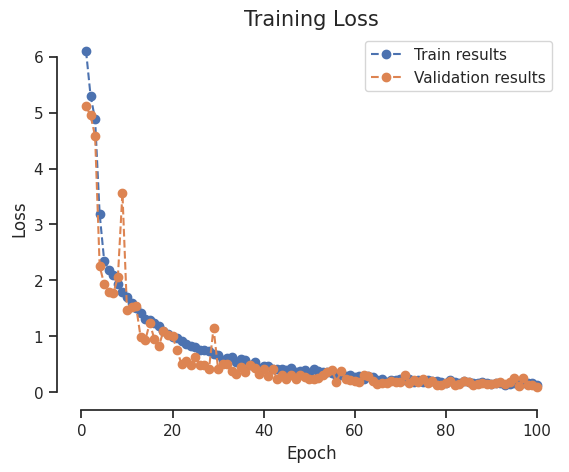

In [145]:
plot('Training Loss', 'Loss', train_loss, val_loss, yscale='linear', save_path=None,extra_pt=None, extra_pt_label=None)

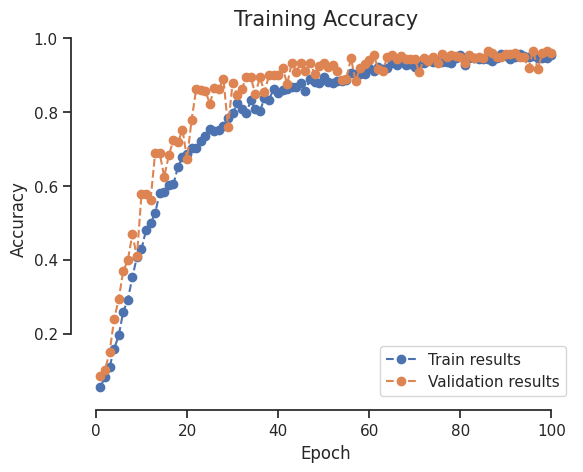

In [146]:
plot('Training Accuracy', 'Accuracy', train_accuracy, val_accuracy, yscale='linear', save_path=None,extra_pt=None, extra_pt_label=None)

In [149]:
res = {
    'tl': train_loss,
    'vl': val_loss,
    'ta': train_accuracy,
    'va': val_accuracy
}

In [150]:
with open('model_training_results_full.json', 'w') as file:
    json_string = json.dumps(res, indent=2)
    file.write(json_string)